In [8]:
import numpy as np
from sklearn.datasets import make_regression

def l1norm_X_and_y_preserve_linearity(X, y, val):
    
    n = X.shape[0]
    d = X.shape[1]
    for i in range(n):
        row_abs_sum = sum(abs(X[i, :]))
        X[i] = X[i]/row_abs_sum
        if val == 1:
            y[i] = y[i]/row_abs_sum
        else:
            ymax = max(abs(y))
            y = y/ymax

    return X, y

n = 10
d = 2
X, y = make_regression(n_samples=n, n_features=d, noise=0)
X, y = l1norm_X_and_y_preserve_linearity(X, y, 0)

# print(X)
xT = X.transpose()
# print(xT)
xTx = np.matmul(xT, X)
print(xTx)

[[2.19292107 0.16870988]
 [0.16870988 3.29703668]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab
from scipy.stats import spearmanr

def genData(mu, sigma, n, d):
    
    for i in range(n):
    
        x = np.random.normal(mu, sigma, size=d).reshape(1,d)
    
        if i==0:
            temp=x
        else:
            temp = np.append(arr=X, values=x, axis=0)

        while np.std(temp) > sigma:
        
            x = np.random.normal(mu, sigma, size=d).reshape(1,d)
            if i==0:
                temp=x
            elif i>0:
                temp = np.append(arr=X, values=x, axis=0)

        x = x.reshape(1,d)
        if i == 0:
            X = x
        elif i>0:
            X = np.append(arr=X, values=x, axis=0)
        
#     print("STD of X is:", np.std(X))
#     print("X:\n", X)

    w = np.random.uniform(low=0.0, high=1.0, size=d).reshape(d,1)
    b = np.random.normal(0, 1, size=n).reshape(n)
#     print("b:\n", b)
#     print("w:\n",w)
    y = np.matmul(X, w).reshape(n) 
#     y = y+b
#     print("y:\n",y)
    return X,y


def l1norm_X_and_y_preserve_linearity(X, y, val):
    
    n = X.shape[0]
    d = X.shape[1]
    for i in range(n):
        row_abs_sum = sum(abs(X[i, :]))
        X[i] = X[i]/row_abs_sum
        if val == 1:
            y[i] = y[i]/row_abs_sum
        else:
            ymax = max(abs(y))
            y = y/ymax

    return X, y


def plotter(X, y, n, d, k, epsilon, jump):
    
    X = X[:n, :d]
    y = y[:n]
    
    rep = 10
    elems = math.floor(((d+2)/2)*(d+1))
    split_val = math.floor(n/5)
    m = math.floor((n-split_val)/jump)
    
    X = np.append(arr=np.ones((n,1)), values=X, axis=1)
    
#     X = minimax_normalise(X)
#     y = minimax_normalise(y.reshape(1, n)).reshape(n)
    X, y = l1norm_X_and_y_preserve_linearity(X,y,0)
    # range of X and y is -1 to 1

    RMSE = np.zeros((k, m))
    priv_RMSE = np.zeros((k, m))
    X_val = np.zeros((m))
    p_corr_rank = np.zeros((m))
    np_corr_rank = np.zeros((m))

    for i in range(k):
    
        X_test = X[i*split_val:(i+1)*split_val, :]
        y_test = y[i*split_val:(i+1)*split_val]
    
        X_without_XTest = X[:i*split_val, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(i+1)*split_val:, :], axis=0)
    
        y_without_yTest = y[:i*split_val]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(i+1)*split_val:], axis=0)
    
        for j in range(m):
            X_val[j] = math.floor((j+1)*jump)
            train_size = math.floor((j+1)*jump)
            X_train = X_without_XTest[:train_size, :]
            y_train = y_without_yTest[:train_size]
        
            xT = X_train.transpose()
            xTx = np.matmul(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx)
            xTy = np.matmul(xT, y_train)
            w = np.matmul(xTx_pinv, xTy)
        
            priv_RMSE_per_lpl = np.zeros((rep))
            
            T_per_rep = np.ones((y_test.shape[0],0))
        
            for l in range(rep):
                b1 = elems/(epsilon)
                b2 = d/epsilon
            
                u_mirr = np.random.laplace(loc=0.0, scale=b1, size = elems)
                
                pos = 0
                u = np.ones((d+1, d+1))
                for r in range(d+1):
                    for c in range(r, d+1):
                        u[c][r] = u_mirr[pos]
                        u[r][c] = u[c][r]
                        pos = pos+1
                v = np.random.laplace(loc=0.0, scale=b2, size = d+1)
            
                sTs = xTx + u
                sTt = xTy + v
                sTs_pinv = np.linalg.pinv(sTs)
                wi = np.matmul(sTs_pinv, sTt)
                T = np.matmul(X_test, wi)
                
                if l == 0:
                    T_per_rep = T.reshape(T.shape[0], 1)
                
                else:
                    T_per_rep = np.append(arr=T_per_rep, values=T.reshape(T.shape[0], 1), axis=1)
                
                priv_RMSE_per_lpl[l] = np.mean(abs(T-y_test)**2)**0.5

            T_avg = sum(T_per_rep.transpose())/rep
            
            corr, p_val = spearmanr(T_avg, y_test)
            p_corr_rank[j] = corr
            
            priv_RMSE[i][j] = np.mean(priv_RMSE_per_lpl)
            y_pred = np.matmul(X_test, w)
            corr, p_val = spearmanr(y_pred, y_test)
            np_corr_rank[j] = corr
            RMSE[i][j] = np.mean(abs(y_pred-y_test)**2)**0.5

    total_RMSE = sum(RMSE)/k
    priv_total_RMSE = sum(priv_RMSE)/k

    RMSE_SD = np.zeros((m))
    priv_RMSE_SD = np.zeros((m))
    for i in range(m):
        RMSE_SD[i] = RMSE[:, i:i+1].std()
        priv_RMSE_SD[i] = priv_RMSE[:, i:i+1].std()

    ans = np.zeros((7,m))
    ans[0] = X_val
    ans[1] = priv_total_RMSE
    ans[2] = priv_RMSE_SD
    ans[3] = total_RMSE
    ans[4] = RMSE_SD
    ans[5] = p_corr_rank
    ans[6] = np_corr_rank

    return ans


In [8]:
n=100000
d=10
X,y = genData(0,1,n,d)
X, y = l1norm_X_and_y_preserve_linearity(X,y,0)

print(max(X.reshape(n*d)))
print(min(X.reshape(n*d)))
print(max(X.reshape(n*d)) - min(X.reshape(n*d)))

0.6319878483620215
-0.6502572137077797
1.2822450620698012


In [9]:
# X_1000 = X[:1000, :]
# y_1000 = y[:1000]

# X_5000 = X[:5000, :]
# y_5000 = y[:5000]

# X_8000 = X[:8000, :]
# y_8000 = y[:8000]

X_10000 = X[:10000, :]
y_10000 = y[:10000]

X_20000 = X[:20000, :]
y_20000 = y[:20000]
X_30000 = X[:30000, :]
y_30000 = y[:30000]
X_40000 = X[:40000, :]
y_40000 = y[:40000]
X_50000 = X[:50000, :]
y_50000 = y[:50000]
X_60000 = X[:60000, :]
y_60000 = y[:60000]
X_70000 = X[:70000, :]
y_70000 = y[:70000]
X_80000 = X[:80000, :]
y_80000 = y[:80000]
X_90000 = X[:90000, :]
y_90000 = y[:90000]
X_100000 = X[:100000, :]
y_100000 = y[:100000]


# X_12000 = X[:12000, :]
# y_12000 = y[:12000]

In [10]:
# xTx_1000 = np.matmul(X_1000.transpose(), X_1000).reshape(d*d)
# print(xTx_1000)
# # print(max(xTx_1000))

# xTx_5000 = np.matmul(X_5000.transpose(), X_5000).reshape(d*d)
# print(xTx_5000)
# # print(max(xTx_5000))

# xTx_8000 = np.matmul(X_8000.transpose(), X_8000).reshape(d*d)
# print(xTx_8000)
# # print(max(xTx_8000))

xTx_100000 = np.matmul(X_100000.transpose(), X_100000).reshape(d*d)
print(xTx_100000)
# print(max(xTx_10000))

# xTx_12000 = np.matmul(X_12000.transpose(), X_12000).reshape(d*d)
# print(xTx_12000)
# print(max(xTx_12000))

[ 1.51773824e+03  7.23527237e+00 -5.40895795e+00  7.03590547e+00
 -3.16027403e+00  3.94859467e+00  7.13994765e+00 -9.67858580e-01
  3.04831416e+00  9.48226622e-02  7.23527237e+00  1.52298098e+03
  6.96169984e+00  3.06655226e+00 -2.14058277e+00  6.55328969e+00
 -3.18249959e+00 -2.58509348e-01  1.85548225e+00  4.58770032e+00
 -5.40895795e+00  6.96169984e+00  1.53077451e+03 -5.24403195e-01
 -1.40651432e+00  4.44700386e+00  1.23568557e+00  8.88085110e+00
  5.89556206e+00  1.52036081e+00  7.03590547e+00  3.06655226e+00
 -5.24403195e-01  1.51519763e+03 -2.40874799e+00 -3.44210735e+00
  4.85319928e+00 -7.07101988e+00  9.17567432e+00 -1.55860546e+00
 -3.16027403e+00 -2.14058277e+00 -1.40651432e+00 -2.40874799e+00
  1.52585442e+03  5.22980908e-01 -1.45018687e+00  3.88654458e+00
  3.32511704e+00 -7.61965427e+00  3.94859467e+00  6.55328969e+00
  4.44700386e+00 -3.44210735e+00  5.22980908e-01  1.50641748e+03
  9.55447391e+00  7.82583819e+00 -3.93990381e+00 -1.27636077e-01
  7.13994765e+00 -3.18249

eps1
eps2
eps3
feat1
eps1
eps2
eps3
feat2
eps1
eps2
eps3
feat3
eps1
eps2
eps3
feat4


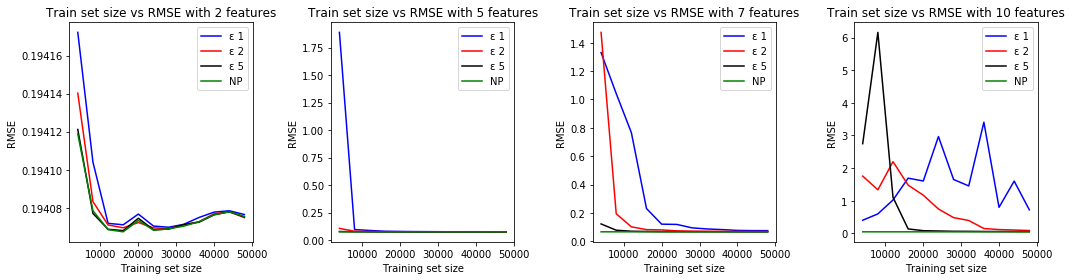

In [155]:
entries = [60000]
features = [2,5,7,10]
k = 5
eps = [1,2,5]
plotnum = 1
pts = 15
colors = ["blue", "red", "black", "orange", "green"]

n=60000
d=10
X,y = genData(0,1,n,d)
for i in range(len(entries)):
    n = entries[i]
    jump = math.floor(n/pts)
    for j in range(len(features)):
        d = features[j]
        plt.rcParams['figure.figsize'] = (15, 4)
        plt.subplot(len(entries),len(features),plotnum)
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = plotter(X, y, n, d, k, epsilon, jump)
        
            print("eps"+str(eps_idx+1))
            plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon))
        print("feat"+str(j+1))   

        plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP")
        plt.xlabel("Training set size")
        plt.ylabel("RMSE")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs RMSE with " + str(d) + " features")
        plotnum = plotnum+1
    plt.tight_layout()
    plt.show()
    


In [153]:
print(X.shape)

(12000, 10)


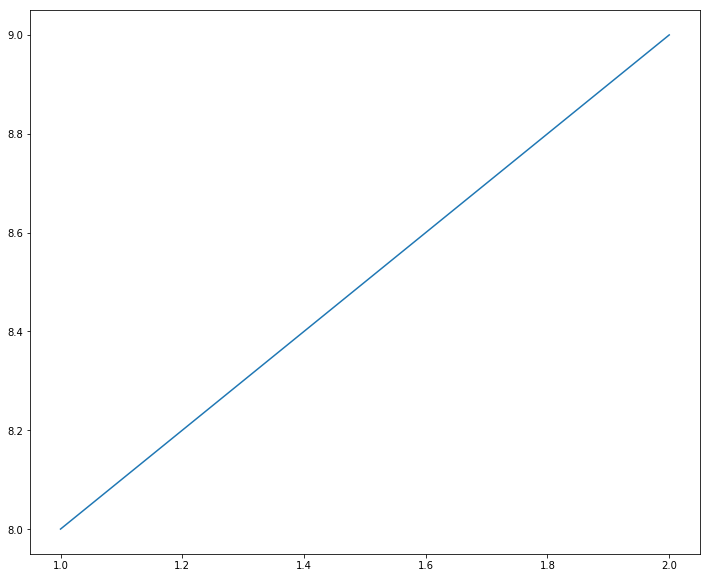

In [25]:
plt.rcParams['figure.figsize'] = (12,10)
plt.subplot(1,1,1)
plt.plot([1,2], [8,9])

# plt.subplot(1,2,2)
# plt.plot([1,2], [8,9])

plt.show()
